### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dictionary Learning

This is a notebook to conduct experiments on the given activations and tokens.
It builds an SAE on an appropriate dimension based on either the residual stream activation as input or the post MLP activation as input.

## SAE

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import json
import random

### Utils

In [ ]:
@torch.no_grad()
def get_recons_loss(num_batches=5, local_encoder=None):
    loss_list = []
    for i in range(num_batches):
        tokens = all_tokens[torch.randperm(len(all_tokens))[:cfg["model_batch_size"]]]
        loss = model(tokens, return_type="loss")
        recons_loss = model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(cfg["act_name"], partial(replacement_hook, encoder=local_encoder))])
        # mean_abl_loss = model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(cfg["act_name"], mean_ablate_hook)])
        zero_abl_loss = model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(cfg["act_name"], zero_ablate_hook)])
        loss_list.append((loss, recons_loss, zero_abl_loss))
    losses = torch.tensor(loss_list)
    loss, recons_loss, zero_abl_loss = losses.mean(0).tolist()

    print(loss, recons_loss, zero_abl_loss)
    score = ((zero_abl_loss - recons_loss)/(zero_abl_loss - loss))
    print(f"{score:.2%}")
    # print(f"{((zero_abl_loss - mean_abl_loss)/(zero_abl_loss - loss)).item():.2%}")
    return score, loss, recons_loss, zero_abl_loss

#### Val Reconstruction Loss

In [ ]:
mse_loss = nn.MSELoss(reduction="mean")

@torch.no_grad()
def compute_val_reconstruction_loss(model, loader_val):
    model.eval()

    total_loss = 0.0
    total_count = 0

    for batch in loader_val:
        val_activations = batch["activations"].to(cfg['device'])      # (B, 768)

        loss, x_reconstruct, acts, l2_loss, l1_loss = model(val_activations)                      # (B, 768)

        batch_size = len(val_activations)
        total_loss += loss.item() * batch_size
        total_count += batch_size

    return total_loss / total_count


#### Get frequencies of activations

Get this to ensure and resample activations

In [ ]:
@torch.no_grad()
def get_freqs(dataset, num_batches=25, local_sae_model=None):
    if local_sae_model is None:
        print("No model provided")
        return

    # ---- build random dataloader ----
    random_loader = DataLoader(
        dataset,
        batch_size=cfg["batch_size"],
        sampler=torch.utils.data.RandomSampler(dataset, replacement=True),
    )

    act_freq_scores = torch.zeros(local_sae_model.d_hidden, dtype=torch.float32).to(cfg["device"])
    total = 0

    # ---- iterate over random batches ----
    for batch_idx, batch in zip(range(num_batches), random_loader):

        # Extract activations from dataset batch
        acts = batch["activations"].to(cfg["device"])
        acts = acts.reshape(-1, cfg["act_size"])  # ensure flat token dimension if needed

        # Pass through encoder
        hidden = local_sae_model(acts)[2]  # (batch, d_hidden)

        # Count positive activations
        act_freq_scores += (hidden > 0).sum(0)

        total += hidden.shape[0]

    # ---- normalize ----
    act_freq_scores /= total

    num_dead = (act_freq_scores == 0).float().mean()
    print("Num dead:", num_dead.item())

    return act_freq_scores


#### Re-init certain activations

In [ ]:
@torch.no_grad()
def re_init(indices, local_sae_model):

    new_W_enc = (torch.nn.init.kaiming_uniform_(torch.zeros_like(local_sae_model.W_enc)))
    new_W_dec = (torch.nn.init.kaiming_uniform_(torch.zeros_like(local_sae_model.W_dec)))
    new_b_enc = (torch.zeros_like(local_sae_model.b_enc))

    print(new_W_dec.shape, new_W_enc.shape, new_b_enc.shape)

    local_sae_model.W_enc.data[:, indices] = new_W_enc[:, indices]
    local_sae_model.W_dec.data[indices, :] = new_W_dec[indices, :]
    local_sae_model.b_enc.data[indices] = new_b_enc[indices]

### Config

In [ ]:
import argparse
def arg_parse_update_cfg(default_cfg):
    """
    Helper function to take in a dictionary of arguments, convert these to command line arguments, look at what was passed in, and return an updated dictionary.

    If in Ipython, just returns with no changes
    """
    if get_ipython() is not None:
        # Is in IPython
        print("In IPython - skipped argparse")
        return default_cfg
    cfg = dict(default_cfg)
    parser = argparse.ArgumentParser()
    for key, value in default_cfg.items():
        if type(value) == bool:
            # argparse for Booleans is broken rip. Now you put in a flag to change the default --{flag} to set True, --{flag} to set False
            if value:
                parser.add_argument(f"--{key}", action="store_false")
            else:
                parser.add_argument(f"--{key}", action="store_true")

        else:
            parser.add_argument(f"--{key}", type=type(value), default=value)
    args = parser.parse_args()
    parsed_args = vars(args)
    cfg.update(parsed_args)
    print("Updated config")
    print(json.dumps(cfg, indent=2))
    return cfg

In [ ]:
def post_init_cfg(cfg):
    cfg["model_batch_size"] = cfg["batch_size"] // cfg["seq_len"] * 16
    cfg["act_size"] = 768
    cfg["dict_size"] = cfg["act_size"] * cfg["dict_mult"]
    cfg["name"] = f"{cfg['dict_size']}"

In [ ]:
default_cfg = {
    "seed": 49,
    "batch_size": 128,
    "lr": 1e-4,
    "l1_coeff": 0.0003,
    "beta1": 0.9,
    "beta2": 0.99,
    "dict_mult": 8,
    "seq_len": 128,
    "enc_dtype":"fp32",
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "model": "gpt2",
    "train_ratio": 0.85,
    "val_ratio": 0.05,
    "test_ratio": 0.1,
    "layer": 9,
    "exp_no": 10
}

In [ ]:
cfg = arg_parse_update_cfg(default_cfg)

In IPython - skipped argparse


In [ ]:
post_init_cfg(cfg)

In [ ]:
SEED = cfg["seed"]
GENERATOR = torch.manual_seed(SEED)
DTYPES = {"fp32": torch.float32, "fp16": torch.float16, "bf16": torch.bfloat16}
np.random.seed(SEED)
random.seed(SEED)
torch.set_grad_enabled(True)

torch.autograd.grad_mode.set_grad_enabled(mode=True)

### Load cfg if test

In [ ]:
SAVE_DIR = f"/content/drive/MyDrive/Colab Notebooks/SLDS_Project/autoencoder_training/exp5_gpt2_16"

with open(os.path.join(SAVE_DIR,"model_cfg.json"), "r") as f:
    cfg = json.load(f)

In [ ]:
cfg

{'seed': 49,
 'batch_size': 128,
 'lr': 0.0001,
 'num_tokens': 138405,
 'l1_coeff': 0.0003,
 'beta1': 0.9,
 'beta2': 0.99,
 'dict_mult': 16,
 'seq_len': 128,
 'enc_dtype': 'fp32',
 'device': 'cpu',
 'model': 'gpt2',
 'train_ratio': 0.85,
 'val_ratio': 0.05,
 'test_ratio': 0.1,
 'layer': 9,
 'exp_no': 5,
 'model_batch_size': 16,
 'act_size': 768,
 'dict_size': 12288,
 'name': '12288'}

### Model Definition

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from pathlib import Path
import pprint

import json
from tqdm import tqdm

In [ ]:
SAVE_DIR = f"/content/drive/MyDrive/Colab Notebooks/SLDS_Project/autoencoder_training/exp{cfg["exp_no"]}_{cfg["model"]}_{cfg["dict_mult"]}"
save_path = Path(SAVE_DIR)
save_path.mkdir(parents=True, exist_ok=True)

In [ ]:
class SparseAutoEncoder(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        d_hidden = cfg["dict_size"]
        l1_coeff = cfg["l1_coeff"]
        dtype = DTYPES[cfg["enc_dtype"]]
        torch.manual_seed(cfg["seed"])
        self.W_enc = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(cfg["act_size"], d_hidden, dtype=dtype)))
        self.W_dec = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_hidden, cfg["act_size"], dtype=dtype)))
        self.b_enc = nn.Parameter(torch.zeros(d_hidden, dtype=dtype))
        self.b_dec = nn.Parameter(torch.zeros(cfg["act_size"], dtype=dtype))

        self.W_dec.data[:] = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)

        self.d_hidden = d_hidden
        self.l1_coeff = l1_coeff

        self.to(cfg["device"])

    def forward(self, x):
        x_cent = x - self.b_dec
        acts = F.relu(x_cent @ self.W_enc + self.b_enc)
        x_reconstruct = acts @ self.W_dec + self.b_dec
        l2_loss = (x_reconstruct.float() - x.float()).pow(2).sum(-1).mean(0)
        l1_loss = self.l1_coeff * (acts.float().abs().sum())
        loss = l2_loss + l1_loss
        return loss, x_reconstruct, acts, l2_loss, l1_loss

    @torch.no_grad()
    def make_decoder_weights_and_grad_unit_norm(self):
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        W_dec_grad_proj = (self.W_dec.grad * W_dec_normed).sum(-1, keepdim=True) * W_dec_normed
        self.W_dec.grad -= W_dec_grad_proj
        # Bugfix(?) for ensuring W_dec retains unit norm, this was not there when I trained my original autoencoders.
        self.W_dec.data = W_dec_normed

    def get_version(self):
        version_list = [int(file.name.split(".")[0]) for file in list(SAVE_DIR.iterdir()) if "pt" in str(file)]
        if len(version_list):
            return 1+max(version_list)
        else:
            return 0

    def save(self):
        version = self.get_version()
        torch.save(self.state_dict(), SAVE_DIR/(str(version)+".pt"))
        with open(SAVE_DIR/(str(version)+"_cfg.json"), "w") as f:
            json.dump(cfg, f)
        print("Saved as version", version)

    @classmethod
    def load(cls, version):
        cfg = (json.load(open(SAVE_DIR/(str(version)+"_cfg.json"), "r")))
        pprint.pprint(cfg)
        self = cls(cfg=cfg)
        self.load_state_dict(torch.load(SAVE_DIR/(str(version)+".pt")))
        return self

In [ ]:
# Save cfg
import os
import json

def make_json_serializable(obj):
    if isinstance(obj, (str, int, float, bool)) or obj is None:
        return obj
    if isinstance(obj, dict):
        return {k: make_json_serializable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [make_json_serializable(v) for v in obj]

    # fallback: convert to string
    return str(obj)

with open(os.path.join(SAVE_DIR, "model_cfg.json"), "w") as f:
    json.dump(make_json_serializable(cfg), f, indent=4)

### Data Loading

In [ ]:
# Dataset
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split, DataLoader

In [ ]:
class ResidualDataset(Dataset):
    def __init__(self, data):
        self.residuals = data["residuals_post_attn"]
        self.tokens = data["tokens"]
        self.sentence_idx = data["sentence_idx"]
        self.position_idx = data["position_idx"]

    def __len__(self):
        return self.residuals.shape[0]

    def __getitem__(self, idx):
        return {
            "activations": self.residuals[idx],
            "token": self.tokens[idx],
            "sentence_idx": self.sentence_idx[idx],
            "position_idx": self.position_idx[idx],
        }

In [ ]:
res_act_file = f"/content/drive/MyDrive/Colab Notebooks/SLDS_Project/token_activations/financial_phrasebank_gpt2_layer{cfg["layer"]}_residuals.pt"

In [ ]:
data = torch.load(res_act_file)

In [ ]:
cfg["num_tokens"] = len(data["tokens"])

In [ ]:
print(data["residuals_post_attn"].shape)   # (total_tokens, 768)
print(len(data["tokens"]))       # total_tokens
print(data["sentence_idx"].shape) # (total_tokens,)
print(data["position_idx"].shape) # (total_tokens,)

torch.Size([138405, 768])
138405
torch.Size([138405])
torch.Size([138405])


In [ ]:
cfg["num_tokens"]/cfg["batch_size"]

1081.2890625

In [ ]:
# Torch dataset
dataset = ResidualDataset(data)

In [ ]:
total = len(dataset)
train_size = int(cfg["train_ratio"] * total)
val_size   = int(cfg["val_ratio"] * total)
test_size  = total - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    lengths=[train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # reproducible
)

train_loader = DataLoader(train_dataset, batch_size=cfg["batch_size"], shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=cfg["batch_size"], shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=cfg["batch_size"], shuffle=False)


### Model Training

In [ ]:
num_batches = cfg["num_tokens"] // cfg["batch_size"]

In [ ]:
sae_model = SparseAutoEncoder(cfg)
sae_model = sae_model.to(cfg['device'])

In [ ]:
optimizer = torch.optim.Adam(sae_model.parameters(), lr=cfg["lr"], betas=(cfg["beta1"], cfg["beta2"]))
val_recons_scores = []
train_loss_list = []

In [ ]:
epochs = 15

In [ ]:
for epoch in range(epochs):

  print(f"Training for epoch - {epoch}")

  for batch_idx, batch in enumerate(train_loader):

      activations = batch["activations"].to(cfg['device'])

      optimizer.zero_grad()

      loss, x_reconstruct, mid_acts, l2_loss, l1_loss = sae_model(activations)
      loss.backward()
      sae_model.make_decoder_weights_and_grad_unit_norm()

      optimizer.step()


      loss_dict = {"loss": loss.item(), "l2_loss": l2_loss.item(), "l1_loss": l1_loss.item()}
      train_loss_list.append(loss_dict)

      if (batch_idx) % 200 == 0:
        print(f"\t Batch {batch_idx}/{num_batches} -> {loss.item()} -> {l2_loss.item()} -> {l1_loss.item()}")

      if (batch_idx) % 1000 == 0:
        print('Getting frequencies')

        # Get frequencies
        freqs = get_freqs(train_dataset, 100, sae_model)

        # Indices to reset
        to_be_reset = (freqs<10**(-5.5))

        # Resetting
        print("Resetting neurons!", to_be_reset.sum())
        re_init(to_be_reset, sae_model)

  # ---- compute validation loss at end of epoch ----
  val_loss = compute_val_reconstruction_loss(sae_model, val_loader)
  print(f"Validation Reconstruction Loss: {val_loss:.6f}")

Training for epoch - 0
	 Batch 0/1081 -> 177705.296875 -> 177476.375 -> 228.91500854492188
Getting frequencies
Num dead: 0.0
Resetting neurons! tensor(0, device='cuda:0')
torch.Size([6144, 768]) torch.Size([768, 6144]) torch.Size([6144])
	 Batch 200/1081 -> 3522.873779296875 -> 3252.98876953125 -> 269.8851013183594
	 Batch 400/1081 -> 2007.8477783203125 -> 1544.302490234375 -> 463.5452575683594
	 Batch 600/1081 -> 1246.1904296875 -> 887.9755859375 -> 358.2148742675781
	 Batch 800/1081 -> 779.517333984375 -> 406.70074462890625 -> 372.8166198730469
Validation Reconstruction Loss: 769.932960
Training for epoch - 1
	 Batch 0/1081 -> 729.6787109375 -> 355.30426025390625 -> 374.37445068359375
Getting frequencies
Num dead: 0.00016276042151730508
Resetting neurons! tensor(1, device='cuda:0')
torch.Size([6144, 768]) torch.Size([768, 6144]) torch.Size([6144])
	 Batch 200/1081 -> 631.45751953125 -> 218.39971923828125 -> 413.0578308105469
	 Batch 400/1081 -> 538.032958984375 -> 138.820068359375 ->

### Save model

In [ ]:
# Save model
weights_path = os.path.join(SAVE_DIR, "model_weight"+".pt")
torch.save(sae_model.state_dict(), weights_path)

In [ ]:
# Save loss list
loss_list_path = os.path.join(SAVE_DIR, "loss_list"+".pt")
torch.save(train_loss_list, loss_list_path)

## Get the test data SAE representations

In [ ]:
import os
import json

In [ ]:
# get config and weight
SAVE_DIR = f"/content/drive/MyDrive/Colab Notebooks/SLDS_Project/autoencoder_training/exp10_gpt2_8"

In [ ]:
weights_path = os.path.join(SAVE_DIR, "model_weight.pt")
sae_model = SparseAutoEncoder(cfg)

In [ ]:
state_dict = torch.load(weights_path)
sae_model.load_state_dict(state_dict)
sae_model.eval()

SparseAutoEncoder()

In [ ]:
# Getting activations and tokens
hidden_activations = []
all_tokens = []

In [ ]:
for batch_idx, batch in enumerate(test_loader):
  activations = batch["activations"].to(cfg['device'])

  # Tokens
  tokens = batch["token"]
  all_tokens.extend(tokens)

  # Get hidden layer weights
  loss, x_reconstruct, mid_acts, l2_loss, l1_loss = sae_model(activations)

  # Store hidden activations
  hidden_activations.append(mid_acts)

In [ ]:
all_tokens_strip = [token.strip().lower() for token in all_tokens]

### Analysis

In [ ]:
hidden_acts_torch = torch.cat(hidden_activations, dim=0)

In [ ]:
# Save directory analysis
save_dir_analysis = f"/content/drive/MyDrive/Colab Notebooks/SLDS_Project/feature_analysis/exp{cfg['exp_no']}/"

os.makedirs(save_dir_analysis, exist_ok=True)

### Feature sparsity

In [ ]:
fired = hidden_acts_torch > 0                      # shape: (N, d)

# Count # of times each feature fires
fire_counts = fired.sum(dim=0)                      # shape: (d,)

# Convert to frequency (percentage of tokens)
frequencies = fire_counts / hidden_acts_torch.size(0)

In [ ]:
frequencies_log10 = torch.log10(frequencies)
print(frequencies, frequencies_log10)

tensor([7.2249e-05, 8.9473e-01, 3.5258e-02,  ..., 8.6114e-01, 5.0574e-04,
        2.1675e-04], device='cuda:0') tensor([-4.1412, -0.0483, -1.4527,  ..., -0.0649, -3.2961, -3.6640],
       device='cuda:0')


In [ ]:
# Taking frequencies which are not 0
frequencies_nonzero = frequencies[frequencies > 0]
frequencies_log10_nonzero = torch.log10(frequencies_nonzero)

In [ ]:
frequencies_log10_nonzero.shape

torch.Size([5871])

### Feature Activation visualization

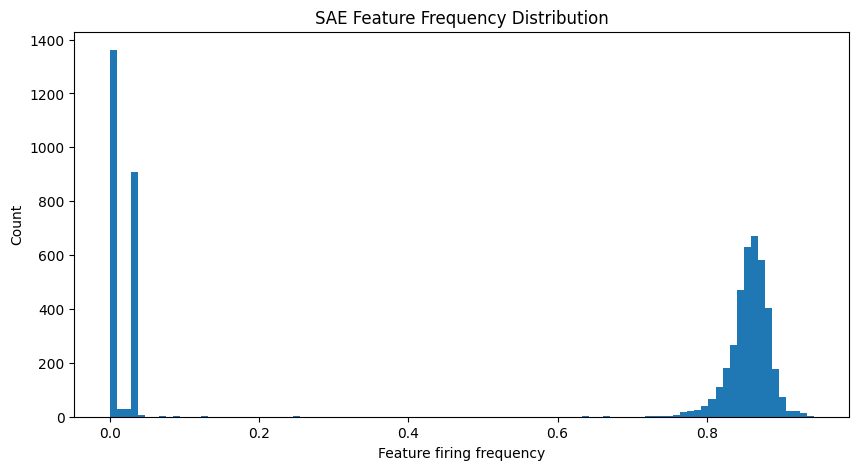

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(frequencies.cpu().numpy(), bins=100)
plt.xlabel("Feature firing frequency")
plt.ylabel("Count")
plt.title("SAE Feature Frequency Distribution")
plt.show()

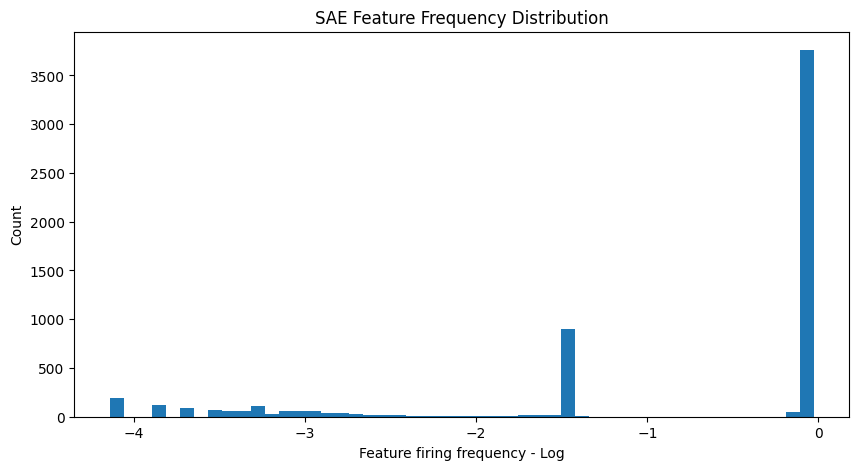

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(frequencies_log10_nonzero.cpu().numpy(), bins=50)
plt.xlabel("Feature firing frequency - Log")
plt.ylabel("Count")
plt.title("SAE Feature Frequency Distribution")

plt.savefig(os.path.join(save_dir_analysis, "feature_frequency_distribution.png"), dpi=300, bbox_inches='tight')


plt.show()

#### Features which are in ultra low density or medium density. Not in high density.

In [ ]:
freq_range_indices = torch.where((torch.log10(frequencies) < -2))[0]

In [ ]:
freq_range_indices.shape

torch.Size([9370])

### Top Tokens (Context) That Activate a Feature

In [ ]:
# Step A — Get top-k tokens
def get_top_k_tokens(feature_id, acts, tokens, k=20):
    feature_acts = acts[:, feature_id]  # (num_tokens,)

    values, indices = torch.sort(feature_acts, descending=True)

    # filter out non-firing
    mask = values > 0
    values = values[mask][:k]
    indices = indices[mask][:k]

    top_tokens = [tokens[i] for i in indices.tolist()]
    return top_tokens, values.cpu()

In [ ]:
# Take unique tokens and sum out activations
from collections import defaultdict


def get_top_token_types(feature_id, acts, tokens, k=20):
    feature_acts = acts[:, feature_id]  # shape: (num_tokens,)

    token_sums = defaultdict(float)

    # accumulate activation for each token *type*
    for tok, act in zip(tokens, feature_acts):
        act_val = act.item()
        if act_val > 0:
            token_sums[tok] += act_val

    # sort by total activation descending
    sorted_tokens = sorted(token_sums.items(), key=lambda x: x[1], reverse=True)

    # return top-k tokens and their summed activation
    top_tokens, top_values = zip(*sorted_tokens[:k])
    return list(top_tokens), torch.tensor(top_values).detach().cpu()

In [ ]:
def plot_top_k_tokens(feature_id, acts, tokens, k=20):
    top_tokens, values = get_top_token_types(feature_id, acts, tokens, k)

    plt.figure(figsize=(6, 6))
    plt.barh(range(len(values)), values.detach().cpu().numpy())
    plt.yticks(range(len(values)), top_tokens)
    plt.xlabel("Activation")
    plt.title(f"Top {k} Tokens for Feature {feature_id}")
    plt.gca().invert_yaxis()
    plt.show()

In [ ]:
len(all_tokens), hidden_acts_torch.shape

(13841, torch.Size([13841, 24576]))

#### Feature 3

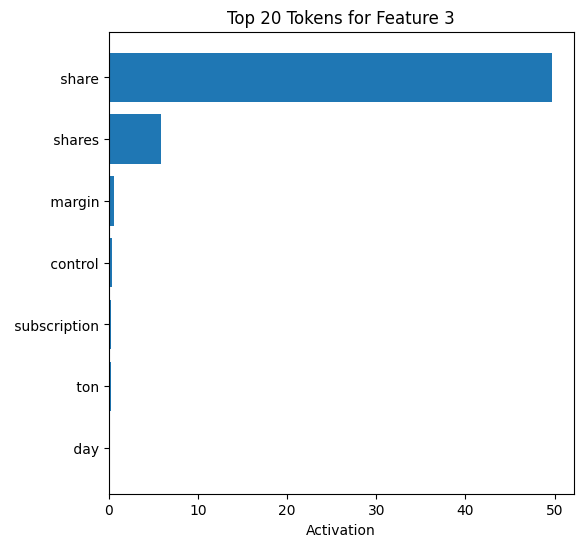

In [ ]:
plot_top_k_tokens(3, hidden_acts_torch, all_tokens, k=20)

#### Feature 4

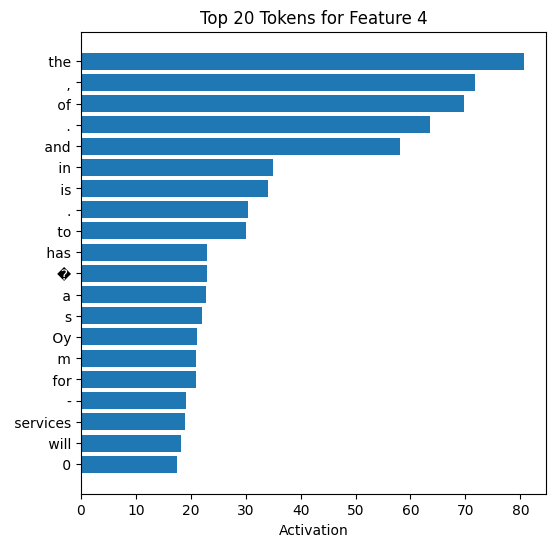

In [ ]:
plot_top_k_tokens(4, hidden_acts_torch, all_tokens, k=20)

#### Feature 5

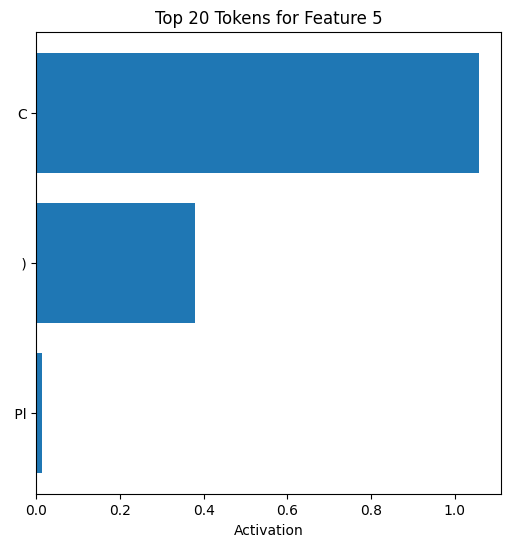

In [ ]:
plot_top_k_tokens(5, hidden_acts_torch, all_tokens, k=20)

#### Feature 732, 636

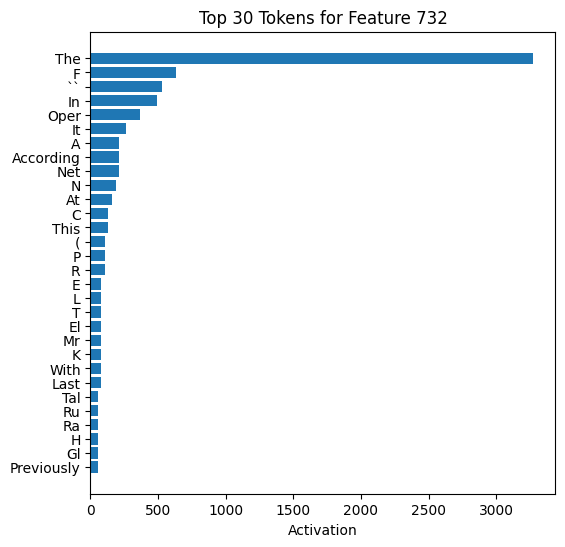

In [ ]:
plot_top_k_tokens(732, hidden_acts_torch, all_tokens, k=30)

#### Loop over each feature and store it in a location

In [ ]:
import os
import torch
import matplotlib.pyplot as plt

def save_feature_top_tokens_images(hidden_acts_torch, tokens_list, feature_ids, save_dir, top_k=20):
    """
    For each latent feature, save an image of top-k tokens activating that feature.

    Args:
        hidden_acts_torch: tensor of shape (num_tokens, num_features)
        tokens_list: list of tokens corresponding to rows in hidden_acts_torch
        save_dir: folder to store images
        top_k: number of top tokens to display per feature
    """
    os.makedirs(save_dir, exist_ok=True)
    num_features = hidden_acts_torch.shape[1]

    for feat_id in tqdm(feature_ids):
        # ---- get top-k tokens ----
        # print(f"{feat_id}/{num_features}", end='\r')
        top_tokens, values = get_top_token_types(feat_id, hidden_acts_torch, tokens_list, top_k)

        # ---- plot ----
        plt.figure(figsize=(6, max(2, top_k * 0.3)))
        plt.barh(range(len(top_tokens))[::-1], values.detach().cpu().numpy(), color='skyblue')
        plt.yticks(range(len(top_tokens))[::-1], top_tokens)
        plt.xlabel("Activation")
        plt.title(f"Feature {feat_id} Top-{top_k} Tokens")
        plt.tight_layout()

        # ---- save figure ----
        plt.savefig(os.path.join(save_dir, f"feature_{feat_id}.png"))
        plt.close()

    print(f"Saved top-{top_k} token images for {num_features} features in {save_dir}")


In [ ]:
# Suppose hidden_acts_torch and tokens_list already exist - take all features
save_dir_top_tokens_for_feature = os.path.join(save_dir_analysis, "top_tokens_for_feature")
os.makedirs(save_dir_top_tokens_for_feature, exist_ok=True)

all_feature_ids = torch.tensor(range(hidden_acts_torch.shape[1]))
save_feature_top_tokens_images(hidden_acts_torch, all_tokens, all_feature_ids, save_dir=save_dir_top_tokens_for_feature, top_k=10)

  0%|          | 34/24576 [00:11<2:17:14,  2.98it/s]


ValueError: not enough values to unpack (expected 2, got 0)

#### Loop over only specific frequency features

Taking log range of -0.3 to -0.2

In [ ]:
freq_range_indices = torch.where((torch.log10(frequencies) < -2) & (torch.log10(frequencies) > -3))[0]
freq_range_indices.shape

torch.Size([1807])

In [ ]:
# Directory
save_dir_top_tokens_for_feature = os.path.join(save_dir_analysis, "top_tokens_for_feature_freq_range_0.3_0.2")
os.makedirs(save_dir_top_tokens_for_feature, exist_ok=True)


# Taking required frequency feature ids
save_feature_top_tokens_images(hidden_acts_torch, all_tokens, freq_range_indices, save_dir=save_dir_top_tokens_for_feature, top_k=20)

100%|██████████| 1807/1807 [11:19<00:00,  2.66it/s]

Saved top-20 token images for 24576 features in /content/drive/MyDrive/Colab Notebooks/SLDS_Project/feature_analysis/exp7/top_tokens_for_feature_freq_range_0.3_0.2


#### Loop over only specific frequency features

Taking log range of between -0.4 and -0.3

In [ ]:
freq_range_indices = torch.where((torch.log10(frequencies) < -3) & (torch.log10(frequencies) > -4))[0]
freq_range_indices.shape

torch.Size([1316])

In [ ]:
# Directory
save_dir_top_tokens_for_feature = os.path.join(save_dir_analysis, "top_tokens_for_feature_freq_range_0.4_0.3")
os.makedirs(save_dir_top_tokens_for_feature, exist_ok=True)

# Taking required frequency feature ids
save_feature_top_tokens_images(hidden_acts_torch, all_tokens, freq_range_indices, save_dir_top_tokens_for_feature, top_k=20)

100%|██████████| 1316/1316 [04:33<00:00,  4.82it/s]

Saved top-20 token images for 12288 features in /content/drive/MyDrive/Colab Notebooks/SLDS_Project/feature_ablation/exp5/top_tokens_for_feature_freq_range_0.4_0.3


### Top Features Activated By Specific Token (Context)

In [ ]:
from collections import defaultdict

def build_token_index_map(tokens):
    token_to_indices = defaultdict(list)
    for i, tok in enumerate(tokens):
        token_to_indices[tok].append(i)
    return token_to_indices

token_to_indices = build_token_index_map(all_tokens_strip)

In [ ]:
def get_feature_activations_for_token(tokens_to_check, hidden_acts_torch, token_to_indices, top_k=20):

    idxs = []
    for token in tokens_to_check:
      if token not in token_to_indices:
          print((f"Token '{token}' not found in dataset"))
      else:
          idxs.extend(token_to_indices[token])           # list of positions

    if idxs == []:
        print("No token found")
        return [], []

    idxs = torch.tensor(idxs)
    acts = hidden_acts_torch[idxs]          # shape: (occurrences, hidden_dim)

    # Average activation across occurrences
    mean_acts = acts.mean(dim=0)             # shape: (hidden_dim,)
    normalized_acts = mean_acts / mean_acts.sum()

    # Get top-k features
    values, feat_ids = torch.topk(normalized_acts, k=top_k)

    # Detach for safety
    return feat_ids.cpu().numpy(), values.detach().cpu().numpy()


In [ ]:
import matplotlib.pyplot as plt

def plot_token_feature_activations(tokens_to_check, feature_ids, activations):
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(feature_ids)), activations)
    plt.xticks(range(len(feature_ids)), feature_ids, rotation=45)
    plt.title(f"Top Activated SAE Features for Tokens: {tokens_to_check}")
    plt.xlabel("Feature ID")
    plt.ylabel("Activation")
    plt.tight_layout()
    plt.show()

#### Features for token Sales

In [ ]:
tokens_to_check = ["sales"]

feature_ids, activations = get_feature_activations_for_token(
    tokens_to_check,
    hidden_acts_torch,
    token_to_indices,
    top_k=20
)

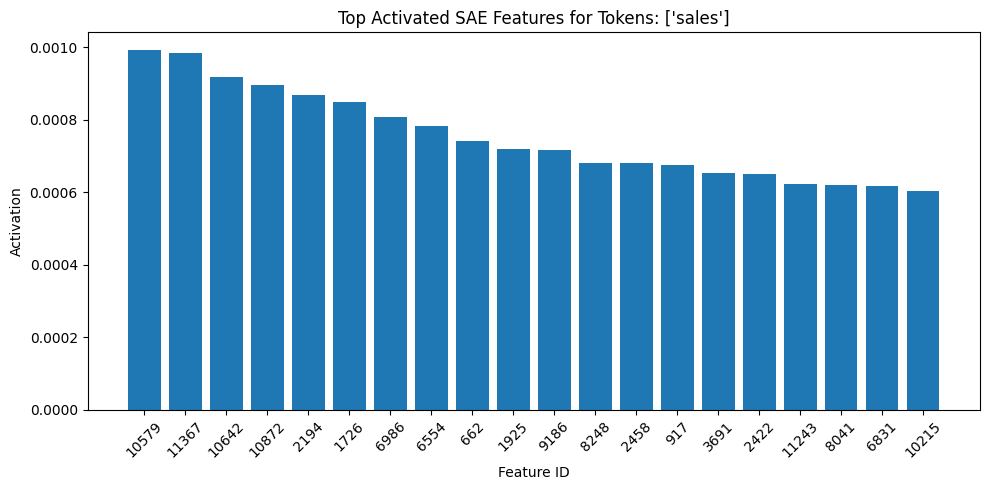

In [ ]:
plot_token_feature_activations(tokens_to_check, feature_ids, activations)

#### Features for Financial Tokens - "profit", "loss", "gain"

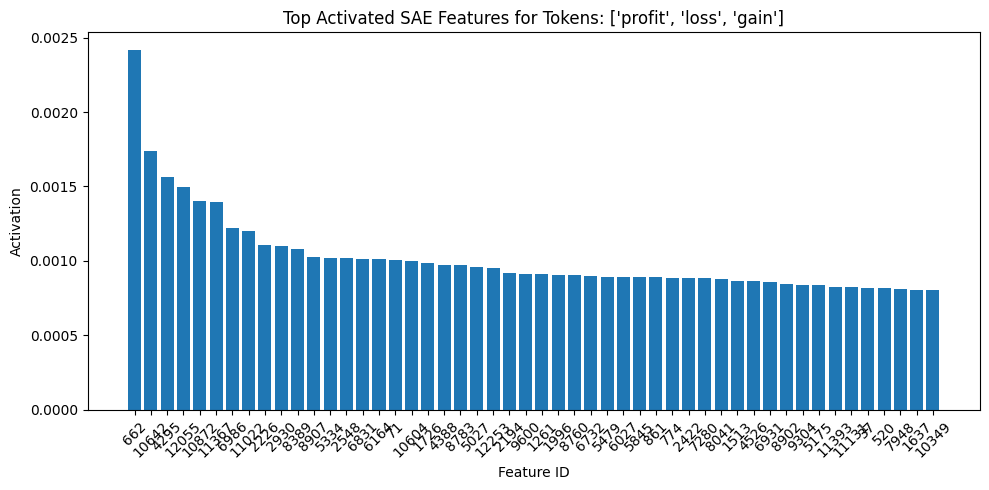

In [ ]:
tokens_to_check = ["profit", "gain"]

feature_ids, activations = get_feature_activations_for_token(
    tokens_to_check,
    hidden_acts_torch,
    token_to_indices,
    top_k=50
)

plot_token_feature_activations(tokens_to_check, feature_ids, activations)

#### Features for Tokens: ["Business"]

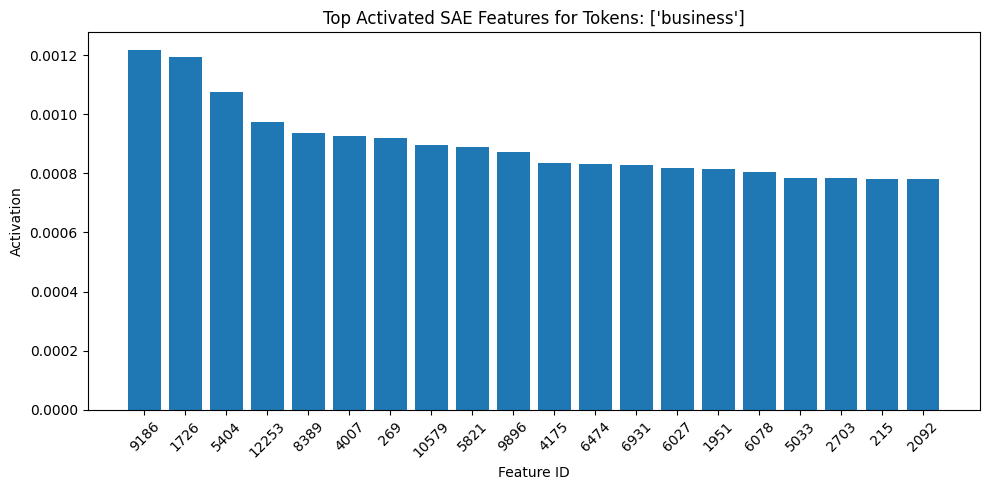

In [ ]:
tokens_to_check = ["business"]

feature_ids, activations = get_feature_activations_for_token(
    tokens_to_check,
    hidden_acts_torch,
    token_to_indices,
    top_k=20
)

plot_token_feature_activations(tokens_to_check, feature_ids, activations)

#### Taking low frequency features instead of all features

In [ ]:
freq_log_treshold = 0.01

frequencies_log10[frequencies_log10 < freq_log_treshold].shape

torch.Size([12288])

In [ ]:
# Take some percent frequencies
hidden_acts_torch_low_freq = hidden_acts_torch[:,frequencies_log10 < 0.01]

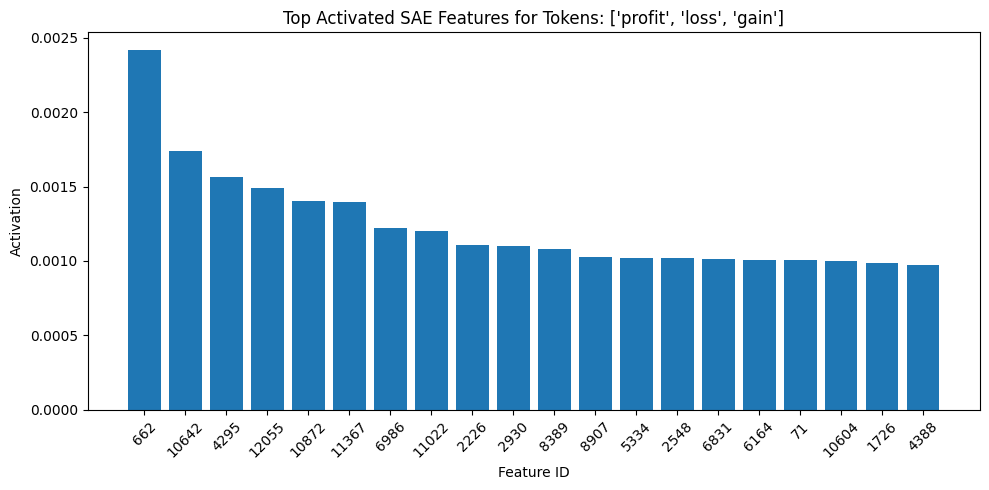

In [ ]:
tokens_to_check = ["profit", "loss", "gain"]

feature_ids, activations = get_feature_activations_for_token(
    tokens_to_check,
    hidden_acts_torch_low_freq,
    token_to_indices,
    top_k=20
)

plot_token_feature_activations(tokens_to_check, feature_ids, activations)

### Finding right set of features to explore

#### We explore our features based on an automated setup to extract features.
---
So we need our features to be specific and sensitive -
Specific - when the SAE feature is on, the context is usually present. It does not turn on with other context.
Sensitive - when the context is present, the SAE feature is usually on.

---
We will focus only on features which activate on less number of tokens. and not on all tokens in the first place.